In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
df = pd.read_csv('../data/data.csv')
df.head()

,Q1S,Q1A,Q1E,Q1I,Q2S,Q2A,Q2E,Q2I,Q3S,Q3A,...,Q32I,age,gender,engnat,country,introelapse,testelapse,surveyelapse,screenw,screenh
0,3,A0A2A1,6861,17,4,A1A2A3A4,6419,23,5,A4A0A2A1A3,...,20,22,2,1,US,73,330,10,320,568
1,1,A9A2A0A3A6,7632,3,1,A3A6A1A5A2,18719,22,5,A4A2A0A3A1,...,7,17,1,2,CA,177,531,9,1920,1080
2,5,A2A4A1A3A0,12243,27,2,A3A0,8547,12,5,A2A4A0A1A3,...,3,37,1,1,US,30,425,9,1680,1050
3,3,A3A4A6A0A1,6894,20,5,A0A2A4A1A3,24992,1,5,A1A3A0A4A2,...,7,17,1,2,HR,8835,99070,9,360,640
4,0,A8A1,16436,11,2,A1A3,8463,3,3,A2A1A4,...,14,20,1,1,US,5,478,7,2560,1440


In [3]:
max_score = 5 * 32
score_students_columns = df.filter(regex='S$', axis=1)
final_score = score_students_columns.sum(axis=1)
grades = (final_score/max_score)*10
df['grade'] = grades
print(df.grade)

0        5.4375
1        3.3750
2        8.0625
3        9.0000
4        6.5000
          ...  
19213    6.7500
19214    4.2500
19215    6.1250
19216    6.3750
19217    4.2500
Name: grade, Length: 19218, dtype: float64


In [4]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        df[['Q15S','Q25S','Q16S','Q19S','Q22S','Q23S','Q1S','Q9S','Q11S','Q27S']],
                                        df['grade'],
                                        random_state = 123
                                    )
# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=123)

In [5]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.7119678063229167


/home/lfresno/Documents/tfg/.venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/lfresno/Documents/tfg/.venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/lfresno/Documents/tfg/.venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/lfresno/Documents/tfg/.venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

Valor óptimo de n_estimators: 146


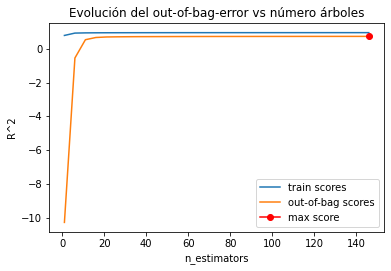

In [6]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

Valor óptimo de n_estimators: 146


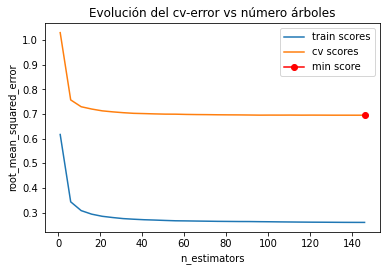

In [7]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Valor óptimo de max_features: 2


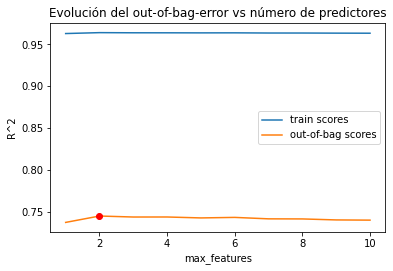

In [8]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

Valor óptimo de max_features: 2


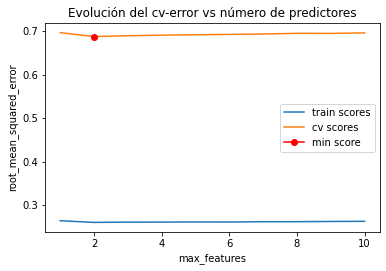

In [9]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

In [10]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
3,0.746737,20.0,5.0,150.0
0,0.745439,NaN,5.0,150.0
2,0.739174,10.0,5.0,150.0
1,0.524318,3.0,5.0,150.0


In [11]:
# VERSIÓN PARALELIZADA
# ==============================================================================

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
def eval_oob_error(X, y, modelo, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo.set_params(
        oob_score    = True,
        n_jobs       = -1,
        random_state = 123,
        ** params            
    )
    
    modelo.fit(X, y)
    
    if verbose:
        print(f"Modelo: {params} \u2713")
        
    return{'params': params, 'oob_r2': modelo.oob_score_}


n_jobs     = multiprocessing.cpu_count() -1
pool       = multiprocessing.Pool(processes=n_jobs)
resultados = pool.starmap(
                eval_oob_error,
                [(X_train, y_train, RandomForestRegressor(), params) for params in param_grid]
             )

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
3,0.746737,20.0,5.0,150.0
0,0.745439,NaN,5.0,150.0
2,0.739174,10.0,5.0,150.0
1,0.524318,3.0,5.0,150.0


In [12]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.7467372312888967 : 0.7467372312888967 R2


In [13]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
9,20,5,150,-0.689981,0.007235,-0.262295,0.000846
0,None,5,150,-0.690249,0.007230,-0.257933,0.000759
10,20,7,150,-0.691412,0.006796,-0.262522,0.000730
1,None,7,150,-0.691727,0.007117,-0.258816,0.000825


In [14]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 20, 'max_features': 5, 'n_estimators': 150} : -0.6899811824271348 neg_root_mean_squared_error


In [15]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.6792251778318804


In [16]:
importancia_predictores = pd.DataFrame(
                            {'predictor': df[['Q15S','Q25S','Q16S','Q19S','Q22S','Q23S','Q1S','Q9S','Q11S','Q27S']].columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,Q1S,0.174524
7,Q9S,0.134433
3,Q19S,0.130718
8,Q11S,0.125957
0,Q15S,0.096986
9,Q27S,0.082173
1,Q25S,0.076671
4,Q22S,0.067591
2,Q16S,0.064713
5,Q23S,0.046233


In [17]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
6,0.571935,0.004628,Q1S
3,0.423616,0.003663,Q19S
8,0.368828,0.001276,Q11S
7,0.340927,0.002830,Q9S
9,0.325742,0.002582,Q27S
0,0.325155,0.002622,Q15S
4,0.280330,0.000659,Q22S
2,0.272429,0.003551,Q16S
1,0.265004,0.001921,Q25S
5,0.193035,0.001398,Q23S


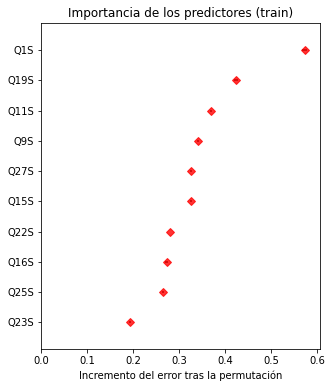

In [18]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');


In [19]:
print(modelo_final.score(X_test, y_test))

0.7508894569735076
